# Real Estate Investment Analysis for Preqin

**Author:** Ishan Yash  

**Objective:**  
> Identify high‑value, high‑liquidity UK residential markets and demonstrate robust handling of missing rent data.


## 1. Setup & Data Loading

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure plots appear inline
%matplotlib inline

# Load the raw dataset
df = pd.read_csv('dataset.csv')

# Quick peek
df.head()

,UK region,Postcode,Avg asking price,Avg asking rent (pm),Sales per month,Avg. bedrooms,Avg. Population
0,East Midlands,DE1,"142,346",628,12.0,2.0,"14,438"
1,East Midlands,DE3,"267,574",775,21.0,3.0,"17,094"
2,East Midlands,DE4,"310,718",757,50.0,3.0,"33,461"
3,East Midlands,DE5,"211,534",624,20.0,3.0,"22,075"
4,East Midlands,DE6,"388,940",NaN,30.0,3.0,"25,599"


In [ ]:
# Histograms and boxplots for numeric columns
numeric_cols = df.select_dtypes(include='number').columns
for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    sns.histplot(df[col].dropna(), ax=axes[0], kde=True)
    axes[0].set_title(f'{col} Histogram')
    sns.boxplot(x=df[col], ax=axes[1])
    axes[1].set_title(f'{col} Boxplot')
    plt.tight_layout()
    plt.show()


In [ ]:
# Scatter matrix (pairplot) to visualize relationships
sns.pairplot(df.select_dtypes(include='number'))
plt.show()


In [ ]:
# Missing data heatmap
plt.figure(figsize=(12,4))
sns.heatmap(df.isna(), cbar=False, yticklabels=False)
plt.title('Missing Data Pattern')
plt.show()


## 2. Data Quality Assessment

**What we’ll do:**  
1. Check shapes & dtypes  
2. Count missing values  
3. Spot duplicates & anomalies

In [5]:
print(f"Rows, cols: {df.shape}")
print(df.dtypes)

Rows, cols: (2185, 7)
UK region                object
Postcode                 object
Avg asking price         object
Avg asking rent (pm)     object
Sales per month         float64
Avg. bedrooms           float64
Avg. Population          object
dtype: object


In [6]:
# Missing & duplicates
missing = df.isna().sum()
dupes  = df.duplicated().sum()
print("Missing per column:\n", missing)

Missing per column:
 UK region                 0
Postcode                  0
Avg asking price         21
Avg asking rent (pm)    945
Sales per month          12
Avg. bedrooms             2
Avg. Population           0
dtype: int64


In [7]:
print("Total duplicate rows:", dupes)

Total duplicate rows: 0


*Observation:* Nearly half of `Avg. Asking Rent` is missing—requires careful imputation.

## 3. Cleaning & Wrangling

- Convert “£1,234,567” → numeric  
- Fix zero‑bedroom entries  
- Drop rows missing critical price/sales


In [8]:
# Helper to strip currency & commas
def to_numeric(x):
    if pd.isna(x): return np.nan
    return float(str(x).replace('£','').replace(',',''))

In [11]:
df.columns

Index(['UK region', 'Postcode', 'Avg asking price', 'Avg asking rent (pm)',
       'Sales per month', 'Avg. bedrooms', 'Avg. Population'],
      dtype='object')

In [14]:
# Apply conversions
df['price'] = df['Avg asking price'].apply(to_numeric)
df['rent']  = df['Avg asking rent (pm)'].apply(to_numeric)
df['pop']   = df['Avg. Population'].apply(lambda x: to_numeric(x))

# Fix 0 bedrooms → 1
df['bedrooms'] = df['Avg. bedrooms'].replace({0:1})

# Drop rows missing price or sales
df = df.dropna(subset=['price','Sales per month']).copy()

# Re‑check
df[['price','rent','pop','bedrooms','Sales per month']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2157 entries, 0 to 2184
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            2157 non-null   float64
 1   rent             1237 non-null   float64
 2   pop              2157 non-null   float64
 3   bedrooms         2157 non-null   float64
 4   Sales per month  2157 non-null   float64
dtypes: float64(5)
memory usage: 101.1 KB


## 4. Feature Engineering

Create investment‑centric metrics:
- **annual_rent**, **gross_yield**  
- **price_per_bed**, **sales_per_capita**  
- regional relative ratios & quantile bins


In [20]:
# Annualise rent and compute yield
df['annual_rent']   = df['rent'] * 12
df['gross_yield']   = df['annual_rent'] / df['price'] * 100

# Price per bedroom
df['price_per_bed'] = df['price'] / df['bedrooms']

# Sales per 10k population
df['sales_per_capita'] = df['Sales per month'] / (df['pop'] / 10000)

# Regional medians - Explicitly select numeric columns
regional = df.groupby('UK region')[['price','rent']].median()
df = df.join(regional, on='UK region', rsuffix='_regmed')

# Ratios to regional medians
df['price_to_regmed'] = df['price'] / df['price_regmed']
df['rent_to_regmed']  = df['rent']  / df['rent_regmed']

# Quantile‐based categories
df['price_cat'] = pd.qcut(df['price'], 4, labels=['Budget','Standard','Premium','Luxury'])
df['yield_cat'] = pd.cut(df['gross_yield'], bins=[0,2,5,8,100], labels=['Low','Moderate','High','Very High'])

df.head()

,UK region,Postcode,Avg asking price,Avg asking rent (pm),Sales per month,Avg. bedrooms,Avg. Population,price,rent,pop,...,annual_rent,gross_yield,price_per_bed,sales_per_capita,price_regmed,rent_regmed,price_to_regmed,rent_to_regmed,price_cat,yield_cat
0,East Midlands,DE1,"142,346",628,12.0,2.0,"14,438",142346.0,628.0,14438.0,...,7536.0,5.294142,71173.000000,8.311400,208276.5,664.5,0.683447,0.945071,Budget,High
1,East Midlands,DE3,"267,574",775,21.0,3.0,"17,094",267574.0,775.0,17094.0,...,9300.0,3.475674,89191.333333,12.285012,208276.5,664.5,1.284706,1.166290,Standard,Moderate
2,East Midlands,DE4,"310,718",757,50.0,3.0,"33,461",310718.0,757.0,33461.0,...,9084.0,2.923551,103572.666667,14.942769,208276.5,664.5,1.491853,1.139202,Premium,Moderate
3,East Midlands,DE5,"211,534",624,20.0,3.0,"22,075",211534.0,624.0,22075.0,...,7488.0,3.539856,70511.333333,9.060023,208276.5,664.5,1.015640,0.939052,Standard,Moderate
4,East Midlands,DE6,"388,940",NaN,30.0,3.0,"25,599",388940.0,NaN,25599.0,...,NaN,NaN,129646.666667,11.719208,208276.5,664.5,1.867421,NaN,Premium,NaN


## 5. Imputation of Missing Rents

**Strategy:**  
1. Median rent‑to‑price by (region, bedrooms)  
2. Fallback to region overall  
3. Peer matching on price & population  
4. Cap yields to [2,8]%  


In [23]:
# Tier 1: group median ratios
grp = df.groupby(['UK region','bedrooms'])[['rent','price']].median()
grp['ratio'] = grp['rent'] / grp['price']

def impute_rent(row):
    if not np.isnan(row['rent']):
        return row['rent']
    key = (row['UK region'], row['bedrooms'])
    if key in grp.index and grp.loc[key,'ratio']>0:
        est = grp.loc[key,'ratio'] * row['price']
    else:
        # Tier 2 fallback
        est = (row['rent_regmed']/row['price_regmed']) * row['price']
    return max(est, 0)

df['rent_imp_raw'] = df.apply(impute_rent, axis=1)
# Cap yields
df['rent_imp'] = (
    df.assign(annual_rent=df['rent_imp_raw']*12)
      .assign(yield_raw=lambda d: d['annual_rent']/d['price']*100)
      .assign(yield_capped=lambda d: d['yield_raw'].clip(2,8))
      .assign(rent_imp=lambda d: d['yield_capped']/100*d['price']/12)
)['rent_imp']

# Use imputed where original missing
df['rent_final'] = df['rent'].fillna(df['rent_imp'])
df['gross_yield'] = df['rent_final']*12/df['price']*100

*Validation:*  
Compare before/after rent distributions to ensure no extreme spikes.


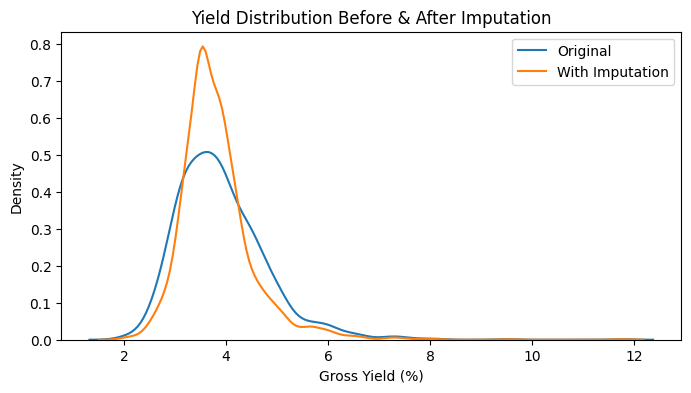

In [24]:
fig, ax = plt.subplots(figsize=(8,4))
sns.kdeplot(df.loc[df['rent'].notna(),'gross_yield'], label='Original', ax=ax)
sns.kdeplot(df['gross_yield'], label='With Imputation', ax=ax)
ax.set(title='Yield Distribution Before & After Imputation', xlabel='Gross Yield (%)')
ax.legend()
plt.show()


## 6. Key Visualizations


### 6.1 Missing‑Rent by Bedroom

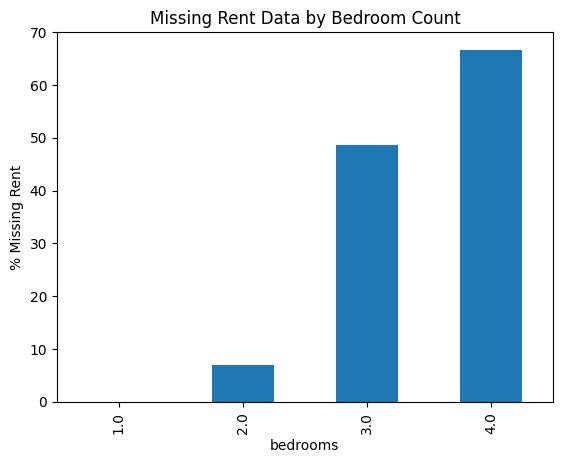

In [25]:
rent_missing = df['rent'].isna().groupby(df['bedrooms']).mean()*100
rent_missing.plot.bar()
plt.ylabel('% Missing Rent')
plt.title('Missing Rent Data by Bedroom Count')
plt.show()


### 6.2 Yield Histogram with Sweet‑Spot

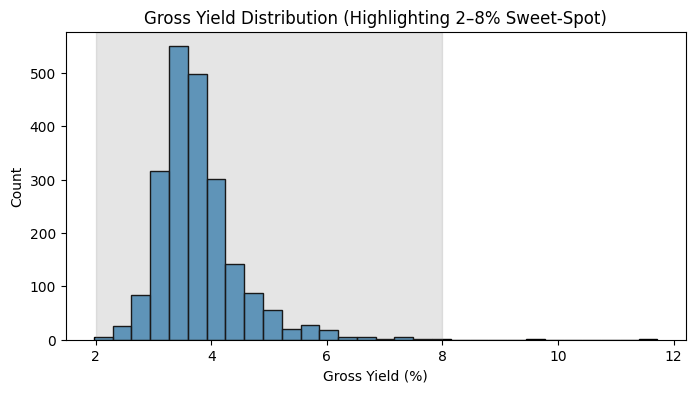

In [26]:
plt.figure(figsize=(8,4))
sns.histplot(df['gross_yield'], bins=30, kde=False)
plt.axvspan(2,8, color='grey', alpha=0.2)
plt.title('Gross Yield Distribution (Highlighting 2–8% Sweet‑Spot)')
plt.xlabel('Gross Yield (%)')
plt.show()


### 6.3 Price‑per‑Bedroom by Region


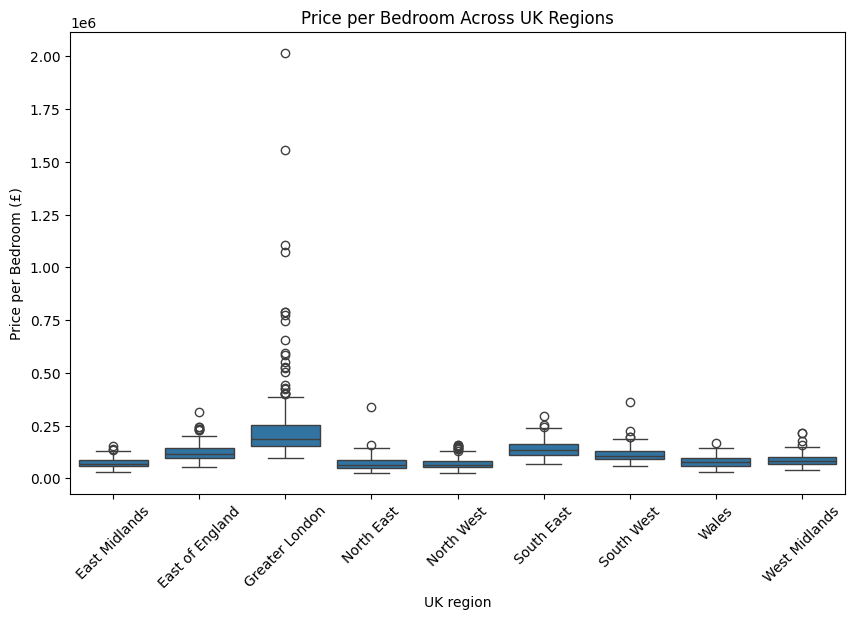

In [28]:
plt.figure(figsize=(10,6))
sns.boxplot(x='UK region', y='price_per_bed', data=df, order=sorted(df['UK region'].unique()))
plt.xticks(rotation=45)
plt.ylabel('Price per Bedroom (£)')
plt.title('Price per Bedroom Across UK Regions')
plt.show()

### 6.4 Liquidity vs. Yield Bubble Chart

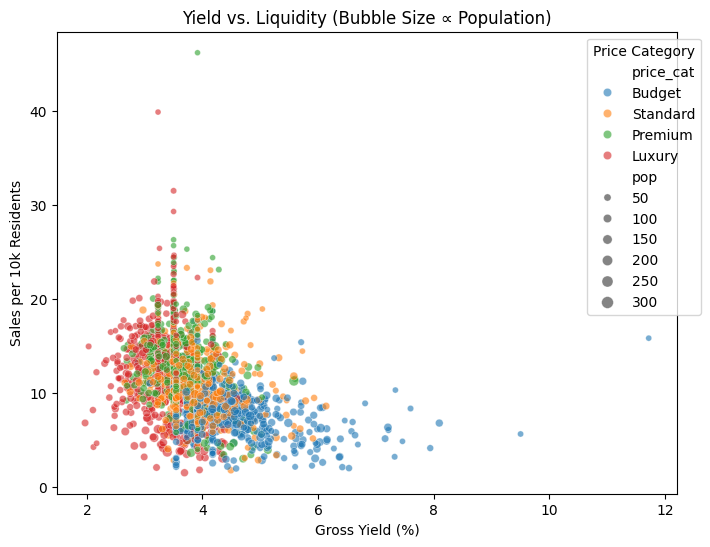

In [30]:
plt.figure(figsize=(8,6))
sizes = (df['pop'] / df['pop'].max()) * 300
sns.scatterplot(x='gross_yield', y='sales_per_capita', size=sizes,
                hue='price_cat', data=df, alpha=0.6, legend='brief')
plt.xlabel('Gross Yield (%)')
plt.ylabel('Sales per 10k Residents')
plt.title('Yield vs. Liquidity (Bubble Size ∝ Population)')
plt.legend(title='Price Category', bbox_to_anchor=(1.05,1))
plt.show()

### 6.5 Regional Price vs. Rent Heatmap


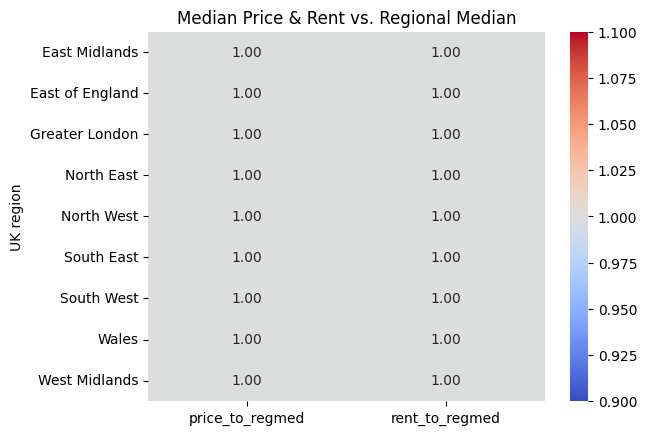

In [32]:
pivot = df.pivot_table(index='UK region',
                       values=['price_to_regmed','rent_to_regmed'], aggfunc='median')
sns.heatmap(pivot, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Median Price & Rent vs. Regional Median')
plt.show()


### 6.6 Imputation Coverage by Region

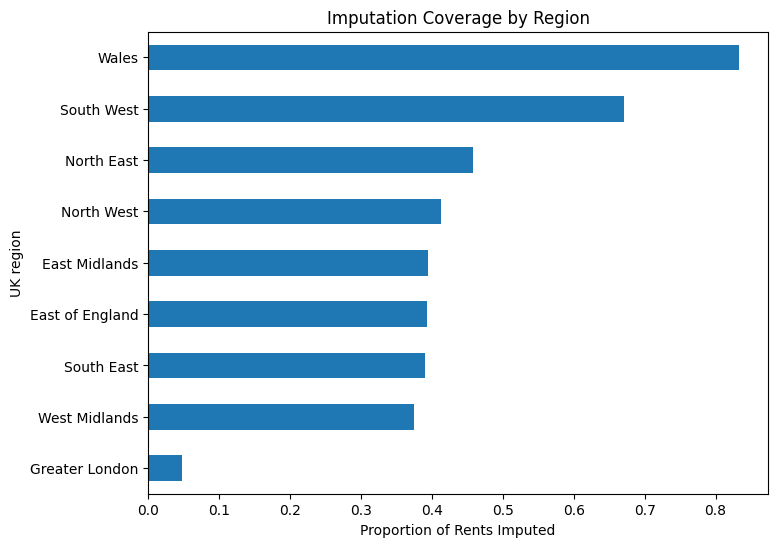

In [34]:
imp_cover = df.assign(imputed=df['rent'].isna()) \
               .groupby('UK region')['imputed'] \
               .agg(['mean','count'])
imp_cover['mean'].sort_values().plot.barh(figsize=(8,6))
plt.xlabel('Proportion of Rents Imputed')
plt.title('Imputation Coverage by Region')
plt.show()

## 7. Conclusions & Recommendations

1. **High‑Yield Pockets (8–10%)** in select Northern postcodes – targets for yield‑focused funds.  
2. **High‑Liquidity Markets** in South West & North West – strong turnover at mid‑range prices.  
3. **Undervalued High‑Population** districts in outer‑London – large tenant pools at below‑median prices.

> **Next Steps:**  
> - Overlay with demographic & employment data for deeper context.  
> - Build an interactive map for stakeholder walkthrough.  
> - Package top 10 postcodes into an investment prospectus.
